In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Excel/Biochemical_parameters.csv", names=["ID", "Data", "Parametro", "Valore"])

indici_da_droppare = df[df['Parametro'] == 'Name'].index
df = df.drop(indici_da_droppare)
df1 = df
df3 = df

df2 = pd.read_csv("Excel/Diagnostics.csv", names=["ID", "Codice", "Complicanza"])

df.describe()

,ID,Data,Parametro,Valore
count,87482,87482,87482,87482
unique,723,1370,17,8192
top,LIB193438,2021-04-14,Creatinine,0.7
freq,846,254,8495,2638


In [55]:
def modified_z_score(series):
    median = np.median(series)
    mad = np.median(np.abs(series - median))
    if mad == 0:
        return np.zeros_like(series)
    return 0.6745 * (series - median) / mad

# Dizionario con unità, intervallo normale e intervallo fuori norma (ma possibili)
param_info = {
    "Creatinine": {"unit": "mg/dL", "normal": (0.6, 1.2), "abnormal": (1.3, 4.0)},
    "Glucose": {"unit": "mg/dL", "normal": (70, 100), "abnormal": ((0, 69), (101, 140))},
    "Potassium": {"unit": "mEq/L", "normal": (3.5, 5.0), "abnormal": ((0, 3.4), (5.1, 6.5))},
    "Sodium": {"unit": "mEq/L", "normal": (136, 146), "abnormal": ((0, 135), (147, 155))},
    "Alanine transaminase (GPT)": {"unit": "U/L", "normal": (7, 56), "abnormal": (57, 100)},
    "Gamma-glutamyl Transferase (GGT)": {"unit": "U/L", "normal": (8, 61), "abnormal": (62, 200)},
    "Total cholesterol": {"unit": "mg/dL", "normal": (0, 200), "abnormal": (201, 299)},
    "Triglycerides": {"unit": "mg/dL", "normal": (0, 150), "abnormal": (151, 500)},
    "HDL cholesterol": {"unit": "mg/dL", "normal": (40, None), "abnormal": (0, 39)},
    "Uric acid": {"unit": "mg/dL", "normal": (3.0, 8.2), "abnormal": ((0, 2.9), (8.3, 12.0))},
    "Glycated hemoglobin (A1c)": {"unit": "%", "normal": (0, 5.7), "abnormal": (5.8, 14.0)},
    "Thyrotropin (TSH)": {"unit": "mIU/L", "normal": (0.4, 4.0), "abnormal": (4.1, 20.0)},
    "Creatinine (urine)": {"unit": "mg/dL", "normal": (((29, 226), "donne"), ((40, 274), "uomini")), "abnormal": ((0, 29), (274, None))},
    "Albumin (urine)": {"unit": "mg/die", "normal": (0, 30), "abnormal": (31, 300)},
    "Chlorine": {"unit": "mEq/L", "normal": (95, 105), "abnormal": ((0, 94), (106, 120))},
    "IA2 ANTIBODIES": {"unit": "U/mL", "normal": (0.0, 7.4), "abnormal": (7.5, 100.0)},
    "Insulin": {"unit": "µIU/mL", "normal": (2.6, 24.9), "abnormal": (25.0, 100.0)}
}

def analisi_parametri(df):
    summary = []
    
    df = df[df["Parametro"] != "Name"]

    for nome, gruppo in df.groupby("Parametro"):
        valori = pd.to_numeric(gruppo["Valore"], errors='coerce')
        totale = len(valori)
        id_unici = gruppo["ID"].nunique()
        mancanti = 723 - id_unici
        
        min = valori.min()
        max = valori.max()
        mean= valori.mean()
        std_val = valori.std()
        # Modified Z-score
        z_scores = modified_z_score(valori)
        z_outliers_idx = np.where(np.abs(z_scores) > 5)[0]
        
        # Valori negativi
        valori_negativi_idx = valori[valori < 0].index

        # Unione degli outlier evitando doppioni
        outlier_idx_unici = set(z_outliers_idx).union(valori_negativi_idx)
        outliers = len(outlier_idx_unici)

        info = param_info.get(nome, {})
        unit = info.get("unit", "")
        normal = info.get("normal", (None, None))
        abnormal = info.get("abnormal", None)

        summary.append([
            nome,
            unit,
            f"{normal[0]}–{normal[1] if normal[1] is not None else ''}",
            str(abnormal),
            totale,
            mancanti,
            min,
            mean,
            max,
            std_val,
            outliers,
        ])
    
    return pd.DataFrame(summary, columns=[
        "Parametro",
        "Unità",
        "Range Normale",
        "Range Fuori Norma (possibile)",
        "Valori Totali",
        "Non Hanno Fatto l’Esame",
        "Minimo",
        "Media",
        "Massimo",
        "Dev. Std",
        "Outliers",
    ])

# Esegui e stampa
tabella_sintesi = analisi_parametri(df)
tabella_sintesi

,Parametro,Unità,Range Normale,Range Fuori Norma (possibile),Valori Totali,Non Hanno Fatto l’Esame,Minimo,Media,Massimo,Dev. Std,Outliers
0,Alanine transaminase (GPT),U/L,7–56,"(57, 100)",7134,1,-4.000,26.981679,868.00,44.617123,302
1,Albumin (urine),mg/die,0–30,"(31, 300)",4283,10,0.010,4.863133,992.20,26.560691,0
2,Chlorine,mEq/L,95–105,"((0, 94), (106, 120))",1935,300,76.000,102.961395,136.00,5.339634,9
3,Creatinine,mg/dL,0.6–1.2,"(1.3, 4.0)",8495,0,0.150,1.044406,11.55,0.947799,656
4,Creatinine (urine),mg/dL,"((29, 226), 'donne')–((40, 274), 'uomini')","((0, 29), (274, None))",4412,10,2.000,114.140306,543.46,66.798995,7
5,Gamma-glutamyl Transferase (GGT),U/L,8–61,"(62, 200)",6085,7,5.000,43.800016,2051.00,113.549983,642
6,Glucose,mg/dL,70–100,"((0, 69), (101, 140))",8349,0,10.000,163.035274,979.00,85.403559,41
7,Glycated hemoglobin (A1c),%,0–5.7,"(5.8, 14.0)",4776,3,4.000,7.823137,18.00,1.385512,48
8,HDL cholesterol,mg/dL,40–,"(0, 39)",5062,6,7.000,56.626827,137.00,14.367272,8
9,IA2 ANTIBODIES,U/mL,0.0–7.4,"(7.5, 100.0)",66,659,0.210,409.637424,6446.74,1237.697950,25


In [7]:
ids_con_complicanze = df2["ID"].unique()

# 2. Dividiamo df1 in due dataset
df_con_complicanze = df1[df1["ID"].isin(ids_con_complicanze)]
df_senza_complicanze = df1[~df1["ID"].isin(ids_con_complicanze)]

# 3. Eseguiamo analisi_parametri su ciascuno
tabella_con = analisi_parametri(df_con_complicanze)
tabella_senza = analisi_parametri(df_senza_complicanze)

tabella_con

,Parametro,Unità,Range Normale,Range Fuori Norma (possibile),Valori Totali,Non Hanno Fatto l’Esame,Minimo,Media,Massimo,Dev. Std,Outliers
0,Alanine transaminase (GPT),U/L,7–56,"(57, 100)",5545,225,-4.000,28.036339,868.00,46.747188,266
1,Albumin (urine),mg/die,0–30,"(31, 300)",3162,228,0.120,5.705658,992.20,29.828967,0
2,Chlorine,mEq/L,95–105,"((0, 94), (106, 120))",1635,407,76.000,102.986116,136.00,5.533705,9
3,Creatinine,mg/dL,0.6–1.2,"(1.3, 4.0)",6684,225,0.150,1.088235,11.55,1.025362,517
4,Creatinine (urine),mg/die,500–2000,"((0, 499), (2001, 5000))",3267,228,2.000,106.331301,515.79,63.222186,8
5,Gamma-glutamyl Transferase (GGT),U/L,8–61,"(62, 200)",4724,228,5.000,46.240157,1903.00,111.824547,507
6,Glucose,mg/dL,70–100,"((0, 69), (101, 140))",6547,225,13.000,164.128914,790.00,84.477618,27
7,Glycated hemoglobin (A1c),%,0–5.7,"(5.8, 14.0)",3490,226,4.000,7.810946,16.40,1.353676,29
8,HDL cholesterol,mg/dL,40–,"(0, 39)",3787,228,7.000,56.778189,132.00,14.687407,6
9,IA2 ANTIBODIES,U/mL,0.0–7.4,"(7.5, 100.0)",40,683,0.210,182.815750,6446.74,1016.574265,14


In [8]:
tabella_senza

,Parametro,Unità,Range Normale,Range Fuori Norma (possibile),Valori Totali,Non Hanno Fatto l’Esame,Minimo,Media,Massimo,Dev. Std,Outliers
0,Alanine transaminase (GPT),U/L,7–56,"(57, 100)",1589,499,6.000,23.301322,709.00,35.987192,44
1,Albumin (urine),mg/die,0–30,"(31, 300)",1121,505,0.010,2.486628,354.07,13.352830,0
2,Chlorine,mEq/L,95–105,"((0, 94), (106, 120))",300,616,86.000,102.826667,121.00,4.129584,2
3,Creatinine,mg/dL,0.6–1.2,"(1.3, 4.0)",1811,498,0.300,0.882645,5.34,0.548145,65
4,Creatinine (urine),mg/die,500–2000,"((0, 499), (2001, 5000))",1145,505,12.000,136.421546,543.46,71.572846,2
5,Gamma-glutamyl Transferase (GGT),U/L,8–61,"(62, 200)",1361,502,5.000,35.330345,2051.00,119.000301,99
6,Glucose,mg/dL,70–100,"((0, 69), (101, 140))",1802,498,10.000,159.061876,979.00,88.596858,16
7,Glycated hemoglobin (A1c),%,0–5.7,"(5.8, 14.0)",1286,500,4.700,7.856221,18.00,1.468472,19
8,HDL cholesterol,mg/dL,40–,"(0, 39)",1275,501,20.000,56.177255,137.00,13.366702,1
9,IA2 ANTIBODIES,U/mL,0.0–7.4,"(7.5, 100.0)",26,699,0.280,758.593846,5683.21,1470.316832,11


In [50]:
# Isola solo le righe con parametro "Creatinina"
creatinina_df = df3[df3["Parametro"] == "Creatinine (urine)"].copy()

# Trova la riga con il valore massimo di creatinina
riga_max = creatinina_df.loc[creatinina_df["Valore"].idxmax()]

# Estrai l'ID corrispondente
ip_max_creatinina = riga_max["ID"]
print(f"IP con creatinina più alta: {ip_max_creatinina}")

# Seleziona tutte le analisi di quella persona (tutti i parametri)
analisi_paziente = df[df["ID"] == ip_max_creatinina]

# Visualizza le analisi
print("\nAnalisi del paziente con creatinina più alta:")
analisi_paziente

IP con creatinina più alta: LIB193774

Analisi del paziente con creatinina più alta:


,ID,Data,Parametro,Valore
53478,LIB193774,2018-07-11,Albumin (urine),11.97
53479,LIB193774,2018-07-11,Total cholesterol,131.0
53480,LIB193774,2018-07-11,Creatinine,0.98
53481,LIB193774,2018-07-11,Creatinine (urine),172.39
53482,LIB193774,2018-07-11,Gamma-glutamyl Transferase (GGT),12.0
53483,LIB193774,2018-07-11,Glucose,139.0
53484,LIB193774,2018-07-11,Glycated hemoglobin (A1c),7.4
53485,LIB193774,2018-07-11,Potassium,4.6
53486,LIB193774,2018-07-11,Triglycerides,171.0
53487,LIB193774,2018-07-11,Alanine transaminase (GPT),10.0


<Figure size 1400x800 with 0 Axes>

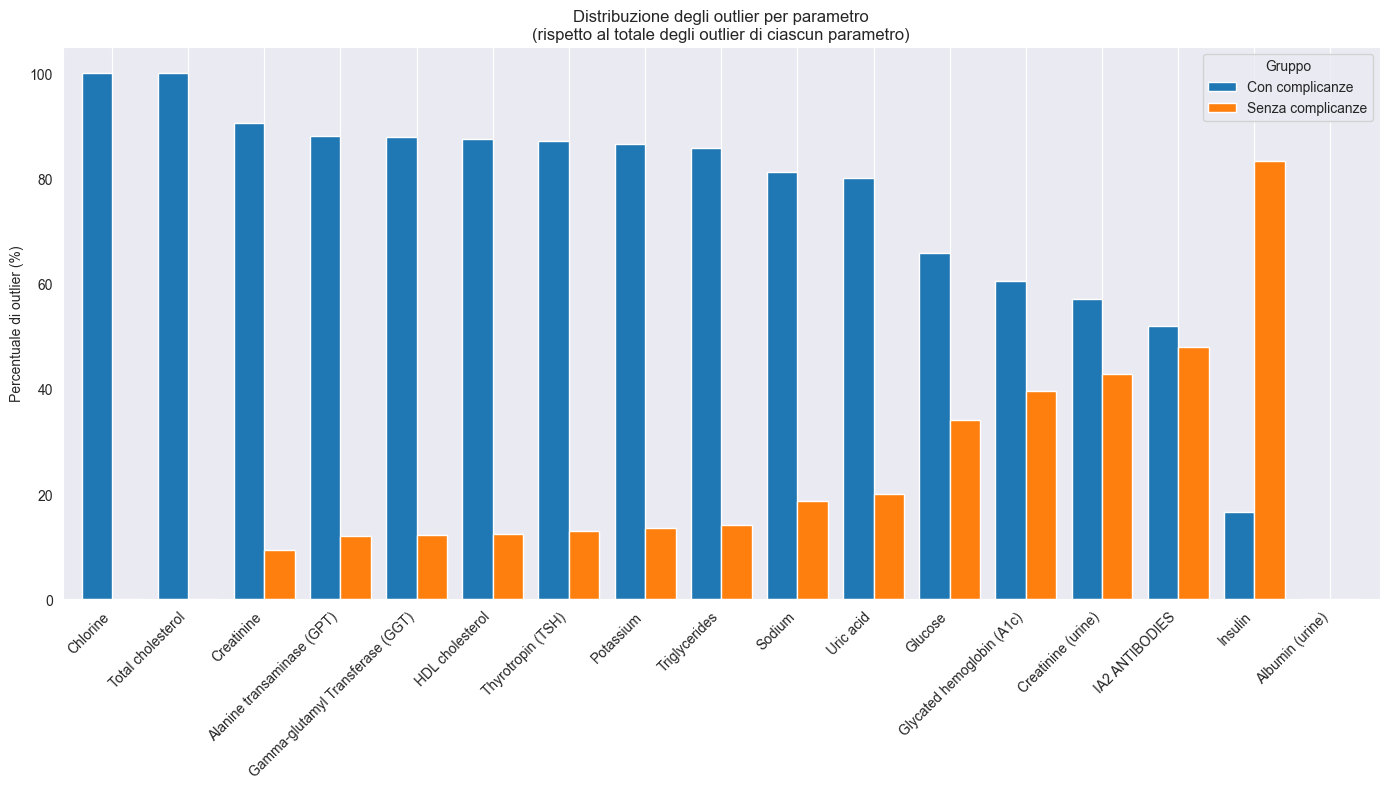

In [38]:
def calcola_percentuali_outlier_rispetto_al_totale(df_completo, df_con, df_senza):
    percentuali_con = {}
    percentuali_senza = {}

    for parametro, gruppo_completo in df_completo.groupby("Parametro"):
        valori_completi = pd.to_numeric(gruppo_completo["Valore"], errors="coerce").dropna()
        if len(valori_completi) == 0:
            percentuali_con[parametro] = 0.0
            percentuali_senza[parametro] = 0.0
            continue

        z_scores = modified_z_score(valori_completi)
        outlier_mask = np.abs(z_scores) > 5
        outliers_parametro = gruppo_completo[outlier_mask]

        totale_outliers = len(outliers_parametro)
        if totale_outliers == 0:
            percentuali_con[parametro] = 0.0
            percentuali_senza[parametro] = 0.0
            continue

        # Conta quanti outlier per quel parametro ci sono in ciascun gruppo
        outliers_con = outliers_parametro[outliers_parametro.index.isin(df_con.index)]
        outliers_senza = outliers_parametro[outliers_parametro.index.isin(df_senza.index)]

        percentuali_con[parametro] = 100 * len(outliers_con) / totale_outliers
        percentuali_senza[parametro] = 100 * len(outliers_senza) / totale_outliers

    return (
        pd.Series(percentuali_con, name="Con complicanze"),
        pd.Series(percentuali_senza, name="Senza complicanze")
    )

# Calcola percentuali rispetto al totale di outlier per ogni parametro
percentuali_con, percentuali_senza = calcola_percentuali_outlier_rispetto_al_totale(
    df1, df_con_complicanze, df_senza_complicanze
)

# Combina i risultati
df_outliers = pd.concat([percentuali_con, percentuali_senza], axis=1).fillna(0)
df_outliers = df_outliers.sort_values(by="Con complicanze", ascending=False)

# Plot
plt.figure(figsize=(14, 8))
df_outliers.plot(kind="bar", figsize=(14, 8), width=0.8)
plt.ylabel("Percentuale di outlier (%)")
plt.title("Distribuzione degli outlier per parametro\n(rispetto al totale degli outlier di ciascun parametro)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.legend(title="Gruppo")
plt.show()

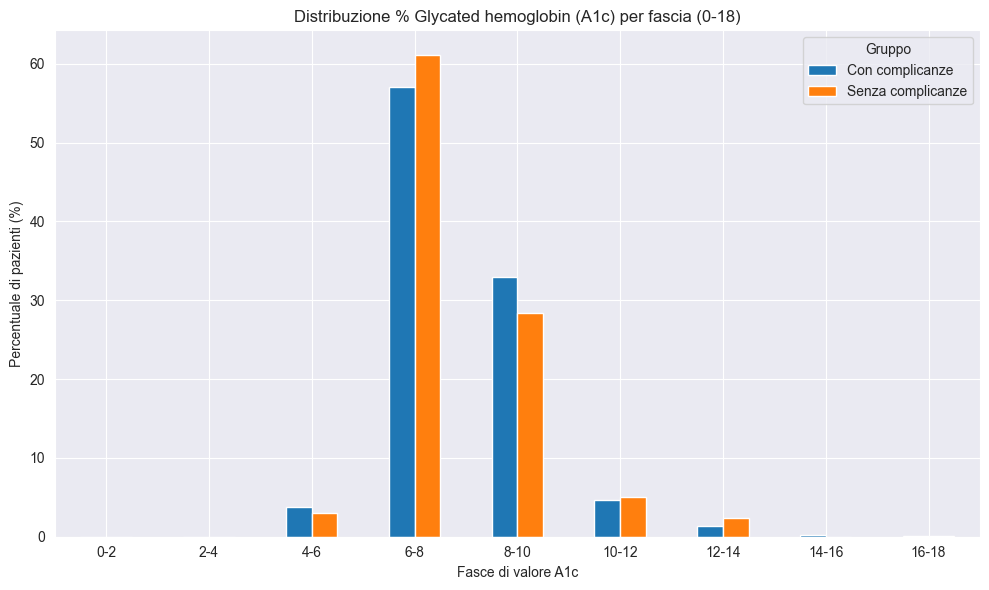

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Filtra solo i valori A1c
a1c_con_raw = df_con_complicanze[df_con_complicanze["Parametro"] == "Glycated hemoglobin (A1c)"]
a1c_senza_raw = df_senza_complicanze[df_senza_complicanze["Parametro"] == "Glycated hemoglobin (A1c)"]

# 2. Converte in numerico (float), rimuovendo eventuali errori
a1c_con = pd.to_numeric(a1c_con_raw["Valore"], errors="coerce").dropna()
a1c_senza = pd.to_numeric(a1c_senza_raw["Valore"], errors="coerce").dropna()

# 3. Definisci le fasce 0–2, 2–4, ..., 16–18
bins = np.arange(0, 20, 2)
labels = [f"{i}-{i+2}" for i in bins[:-1]]

# 4. Fasce con pd.cut()
a1c_con_binned = pd.cut(a1c_con, bins=bins, labels=labels, right=False)
a1c_senza_binned = pd.cut(a1c_senza, bins=bins, labels=labels, right=False)

# 5. Frequenze normalizzate (percentuali)
freq_con = a1c_con_binned.value_counts(normalize=True).sort_index() * 100
freq_senza = a1c_senza_binned.value_counts(normalize=True).sort_index() * 100

# 6. Crea DataFrame per il grafico
df_plot = pd.DataFrame({
    "Con complicanze": freq_con,
    "Senza complicanze": freq_senza
})

# 7. Plot
df_plot.plot(kind="bar", figsize=(10, 6))
plt.title("Distribuzione % Glycated hemoglobin (A1c) per fascia (0-18)")
plt.xlabel("Fasce di valore A1c")
plt.ylabel("Percentuale di pazienti (%)")
plt.xticks(rotation=0)
plt.legend(title="Gruppo")
plt.tight_layout()
plt.show()

In [17]:
df1["Data"] = pd.to_datetime(df1["Data"])

# Ottieni la prima data per ogni parametro per ciascun paziente
first_dates = df1.groupby(["ID", "Parametro"])["Data"].min().reset_index()
first_dates

,ID,Parametro,Data
0,LIB193265,Alanine transaminase (GPT),2018-09-05
1,LIB193265,Albumin (urine),2021-01-18
2,LIB193265,Chlorine,2018-09-05
3,LIB193265,Creatinine,2018-09-05
4,LIB193265,Creatinine (urine),2021-01-18
...,...,...,...
10584,LIB194166,Sodium,2020-12-10
10585,LIB194166,Thyrotropin (TSH),2020-12-10
10586,LIB194166,Total cholesterol,2020-12-10
10587,LIB194166,Triglycerides,2020-12-10


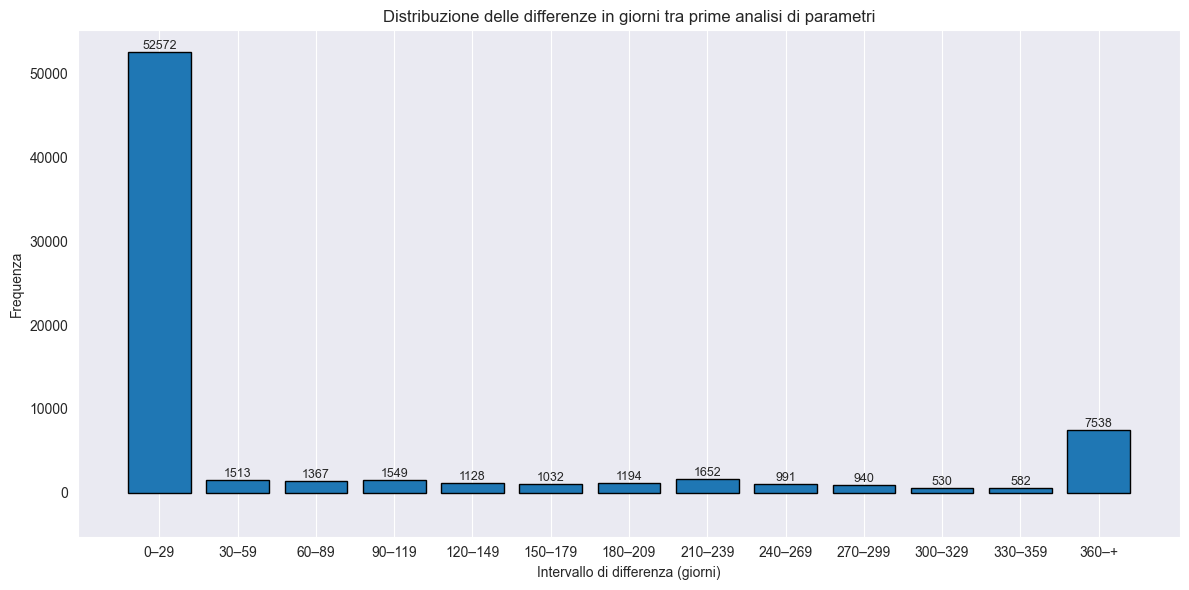

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

records = []

for patient_id, group in first_dates.groupby("ID"):
    params = group.set_index("Parametro")["Data"].to_dict()
    for (p1, p2) in combinations(params.keys(), 2):
        delta = abs((params[p1] - params[p2]).days)
        records.append({
            "ID": patient_id,
            "Parametro 1": p1,
            "Parametro 2": p2,
            "Differenza giorni": delta
        })

df_diff = pd.DataFrame(records)

# 🎯 Definizione intervalli
bin_ranges = [(i, i+29) for i in range(0, 360, 30)]
bin_ranges.append((360, float('inf')))  # Ultimo intervallo: 360+

# Etichette leggibili
bin_labels = [f"{start}–{end if end != float('inf') else '+'}" for start, end in bin_ranges]

# Conta quanti valori cadono in ciascun intervallo
bin_counts = []
for start, end in bin_ranges:
    count = df_diff[
        (df_diff["Differenza giorni"] >= start) &
        (df_diff["Differenza giorni"] <= end if end != float('inf') else True)
    ].shape[0]
    bin_counts.append(count)

# 🎨 Grafico a barre con larghezza costante
plt.figure(figsize=(12, 6))
bars = plt.bar(bin_labels, bin_counts, edgecolor='black')

# Etichette sopra e sotto
for bar, count in zip(bars, bin_counts):
    x = bar.get_x() + bar.get_width() / 2
    if count > 0:
        plt.text(x, count, str(count), ha='center', va='bottom', fontsize=9)

plt.title("Distribuzione delle differenze in giorni tra prime analisi di parametri")
plt.xlabel("Intervallo di differenza (giorni)")
plt.ylabel("Frequenza")
plt.grid(axis='y')
plt.tight_layout()
plt.ylim(bottom=-max(bin_counts)*0.1)
plt.show()

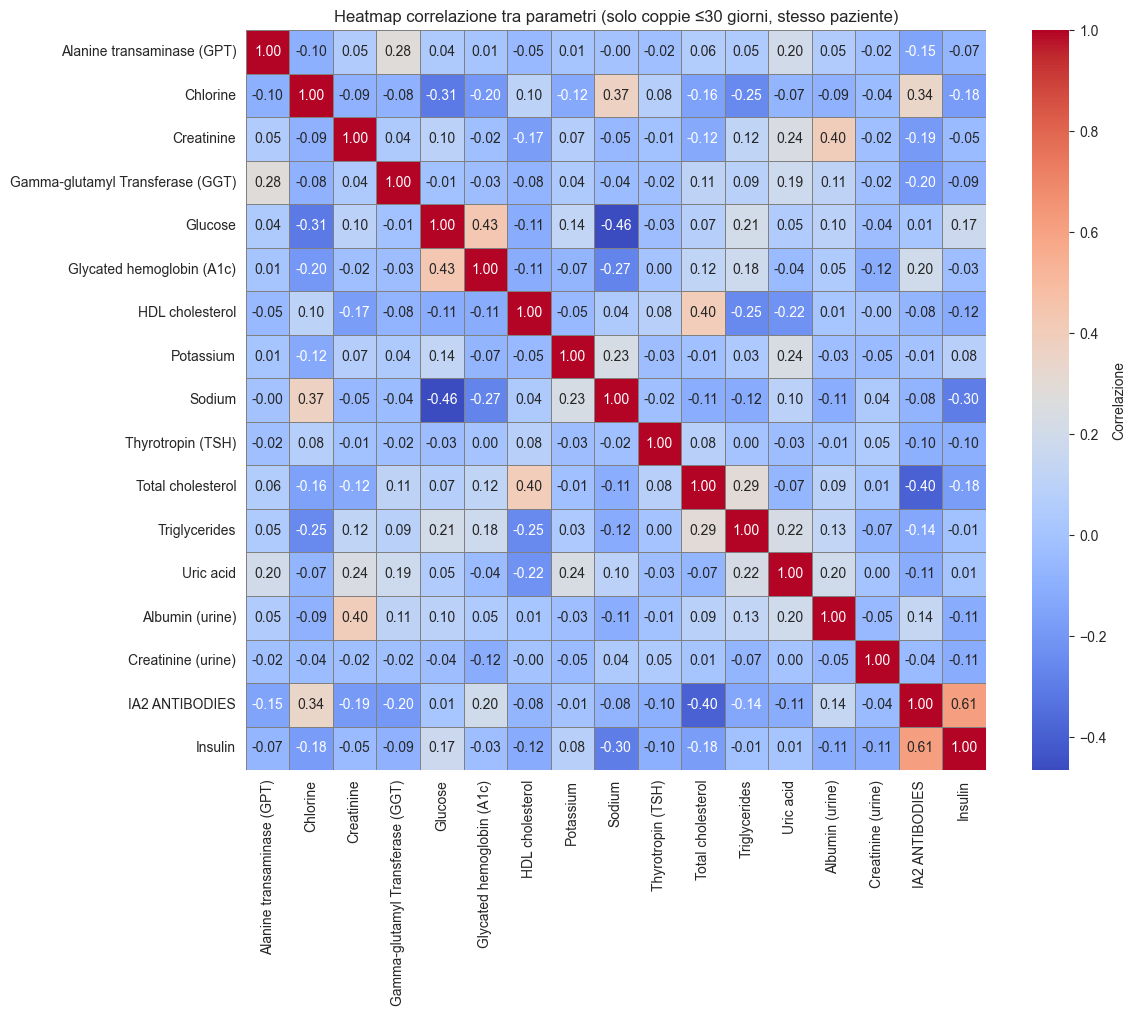

In [21]:
records = []

# Analisi per paziente
for patient_id, group in first_dates.groupby("ID"):
    # Dizionari per data e valore per parametro
    date_dict = group.set_index("Parametro")["Data"].to_dict()
    value_dict = df1[df1["ID"] == patient_id].groupby("Parametro")["Valore"].first().to_dict()

    for p1, p2 in combinations(date_dict.keys(), 2):
        delta_days = abs((date_dict[p1] - date_dict[p2]).days)
        if delta_days <= 30:
            val1 = pd.to_numeric(value_dict.get(p1), errors="coerce")
            val2 = pd.to_numeric(value_dict.get(p2), errors="coerce")
            if pd.notna(val1) and pd.notna(val2):
                records.append({
                    "ID": patient_id,
                    p1: val1,
                    p2: val2
                })

# Trasforma in DataFrame
df_corr_raw = pd.DataFrame(records)

# Raggruppa per ID e calcola la media dei valori duplicati
df_corr_wide = df_corr_raw.groupby("ID").mean(numeric_only=True)

# Calcola matrice di correlazione
correlation_matrix = df_corr_wide.corr()

# Plot della heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            cbar_kws={'label': 'Correlazione'}, linewidths=0.5, linecolor='gray')
plt.title("Heatmap correlazione tra parametri (solo coppie ≤30 giorni, stesso paziente)")
plt.tight_layout()
plt.show()

C:\Users\gabry\AppData\Local\Temp\ipykernel_26560\3805047281.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_con_complicanze["Complicanze"] = "Con complicanze"
C:\Users\gabry\AppData\Local\Temp\ipykernel_26560\3805047281.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_senza_complicanze["Complicanze"] = "Senza complicanze"


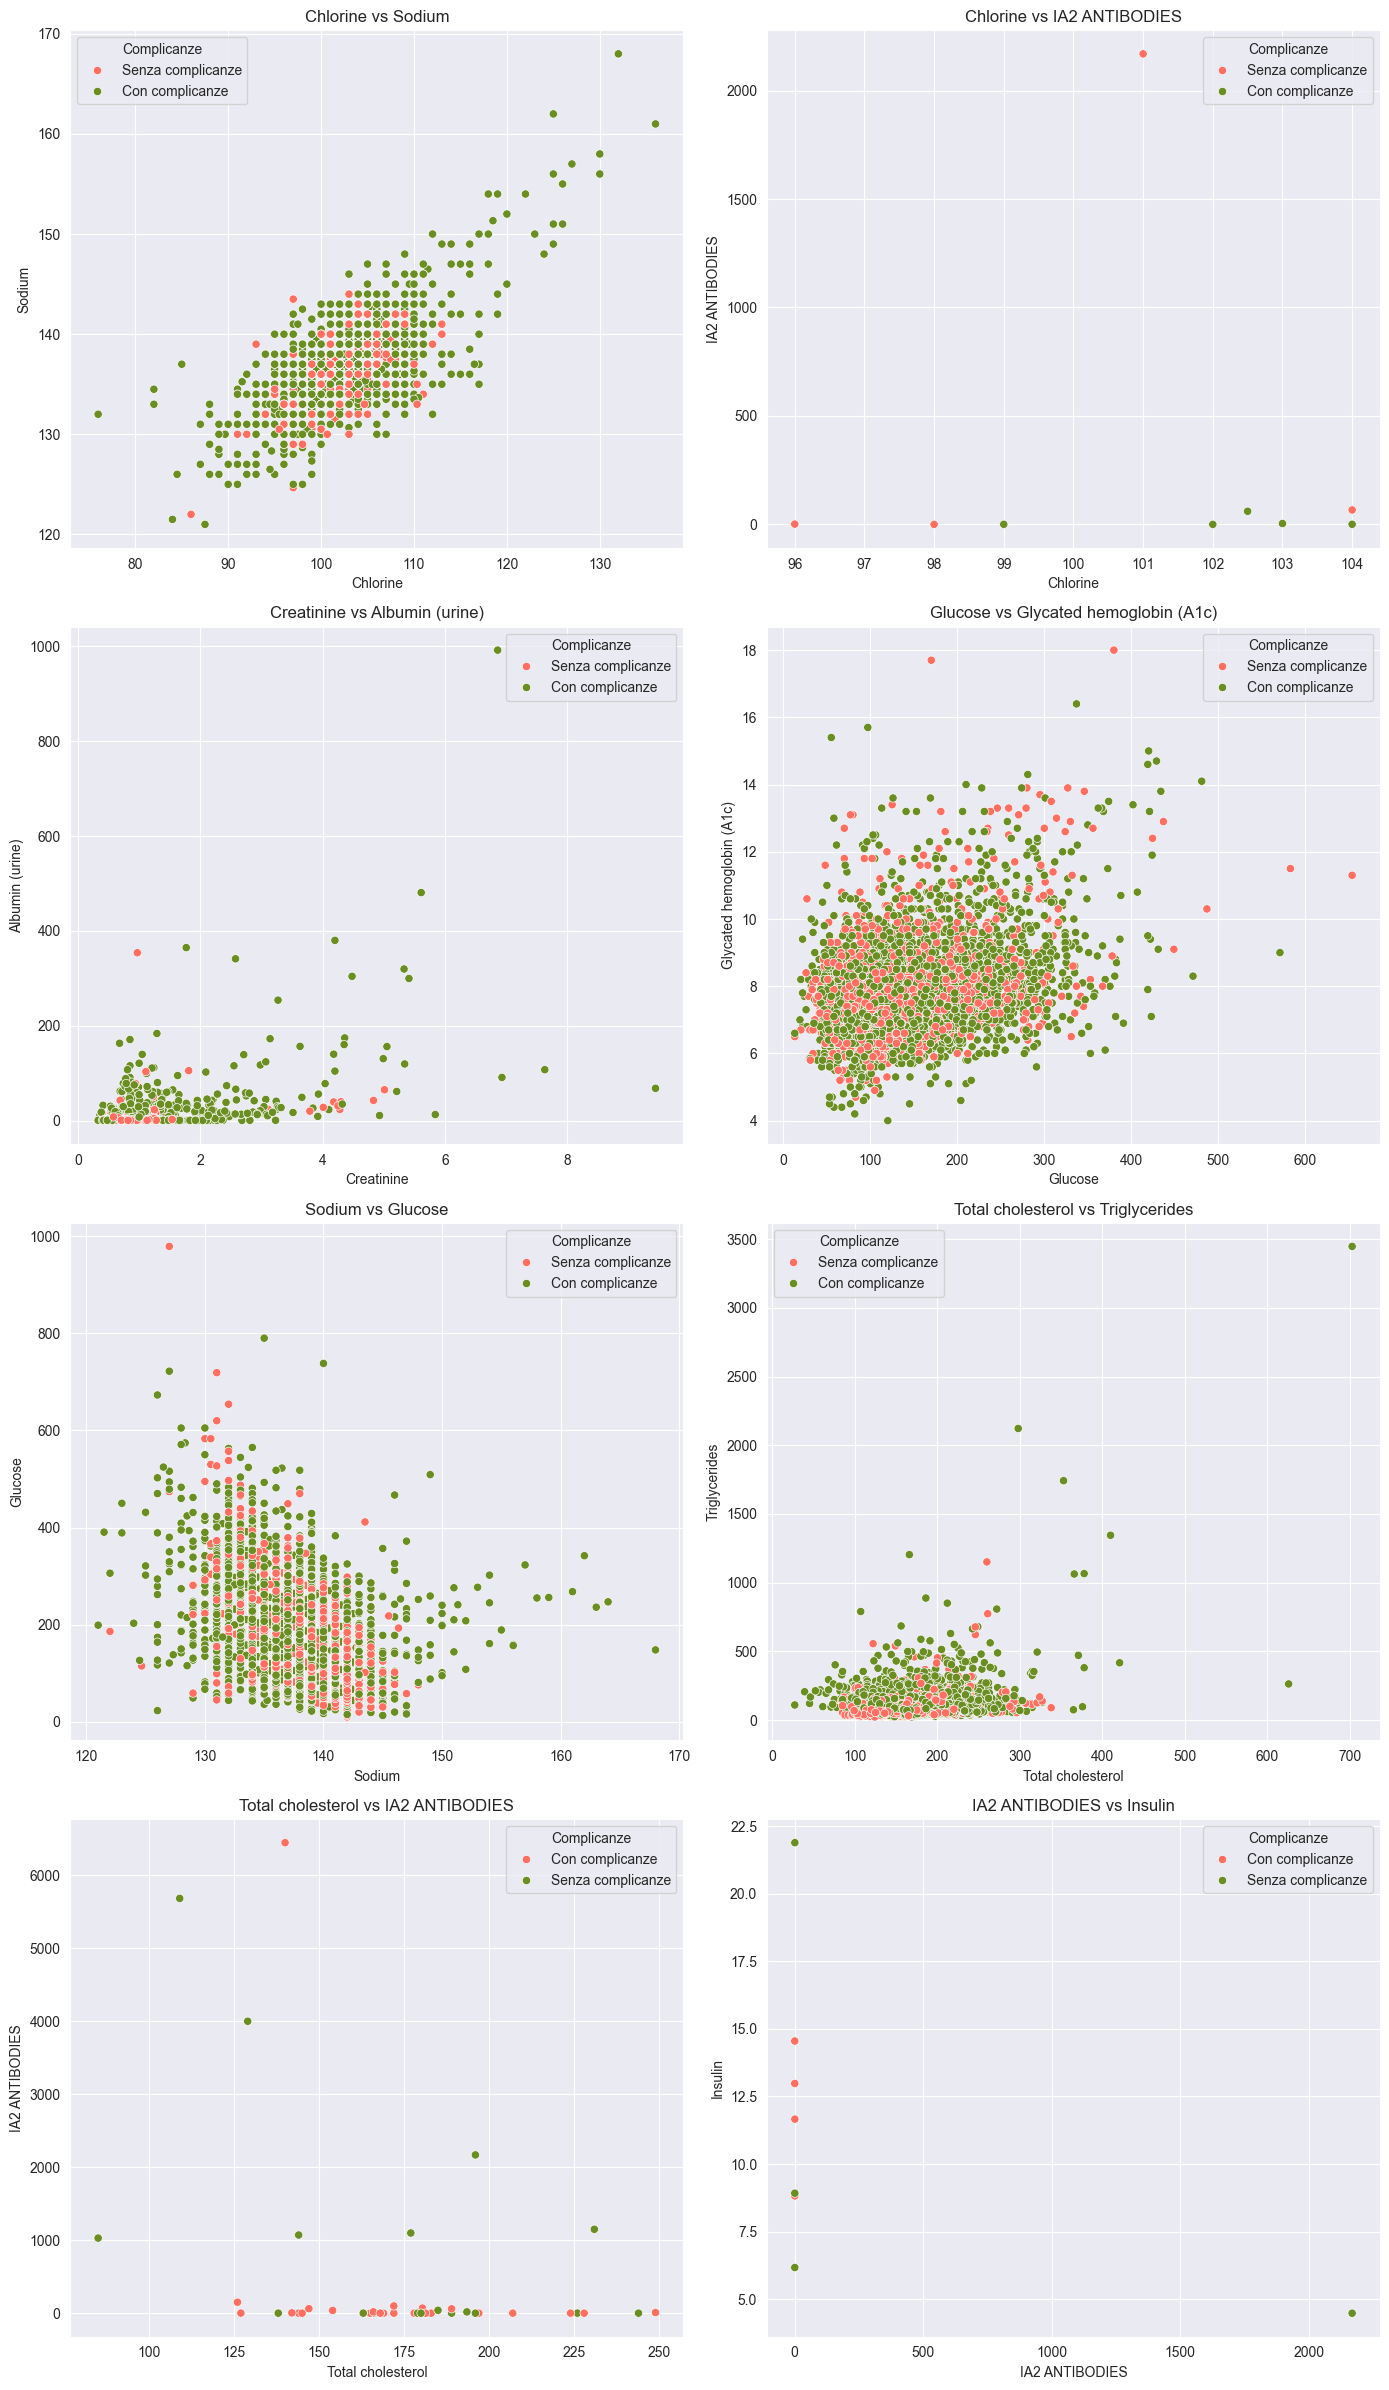

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Parametri interessanti dalla heatmap (puoi modificarli o estenderli)
combinazioni_interessanti = [
    ("Chlorine", "Sodium"),
    ("Chlorine", "IA2 ANTIBODIES"),
    ("Creatinine", "Albumin (urine)"),
    ("Glucose", "Glycated hemoglobin (A1c)"),
    ("Sodium", "Glucose"),  # Correlazione negativa
    ("Total cholesterol", "Triglycerides"),
    ("Total cholesterol", "IA2 ANTIBODIES"), # Correlazione negativa
    ("IA2 ANTIBODIES", "Insulin")
]

# Crea la colonna "Complicanze"
df_con_complicanze["Complicanze"] = "Con complicanze"
df_senza_complicanze["Complicanze"] = "Senza complicanze"

# Unione dei due dataset
df_merged = pd.concat([df_con_complicanze, df_senza_complicanze], ignore_index=True)

# Conversione a numerico e datetime
df_merged["Valore"] = pd.to_numeric(df_merged["Valore"], errors="coerce")
df_merged["Data"] = pd.to_datetime(df_merged["Data"], errors="coerce")

# Prepara i subplot
n = len(combinazioni_interessanti)
cols = 2
rows = (n + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(14, 6 * rows))
axes = axes.flatten()

# Loop per ogni coppia
for i, (p1, p2) in enumerate(combinazioni_interessanti):
    df_wide = df_merged.pivot_table(
        index=["ID", "Data", "Complicanze"],
        columns="Parametro",
        values="Valore",
        aggfunc="mean"
    ).reset_index()

    if p1 in df_wide.columns and p2 in df_wide.columns:
        df_plot = df_wide[[p1, p2, "Complicanze"]].dropna()

        sns.scatterplot(data=df_plot, x=p1, y=p2, hue="Complicanze",
                        palette=["#FF6F61", "#6B8E23"], ax=axes[i])
        axes[i].set_title(f"{p1} vs {p2}")
        axes[i].grid(True)
    else:
        axes[i].text(0.5, 0.5, f"Parametri non trovati:\n{p1}, {p2}",
                     ha='center', va='center')
        axes[i].set_axis_off()

# Rimuove eventuali assi in eccesso
for j in range(i + 1, len(axes)):
    axes[j].set_axis_off()

plt.tight_layout()
plt.show()